In [52]:
#import packages 
import numpy as np
import pandas as pd
import scipy.stats as sts
import os
import matplotlib.pyplot as plt
import scipy.optimize as opt
import warnings
warnings.filterwarnings('ignore')
from scipy import special
from scipy.integrate import quad
from scipy.linalg import pinv

In [78]:
data = np.loadtxt('usincmoms.txt')
data[:,1]


array([  2500.,   7500.,  12500.,  17500.,  22500.,  27500.,  32500.,
        37500.,  42500.,  47500.,  52500.,  57500.,  62500.,  67500.,
        72500.,  77500.,  82500.,  87500.,  92500.,  97500., 102500.,
       107500., 112500., 117500., 122500., 127500., 132500., 137500.,
       142500., 147500., 152500., 157500., 162500., 167500., 172500.,
       177500., 182500., 187500., 192500., 197500., 225000., 300000.])

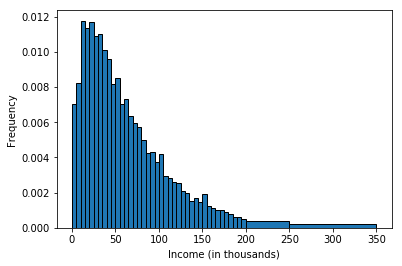

In [79]:
width = np.hstack([np.ones(len(data[:,1]) - 2)*5, 50, 100])
left=data[:,1]/1000

b=np.hstack([data[:, 0][:-2], data[:, 0][-2]/10, data[:, 0][-1]/20])/5
plt.bar(left, b, width, edgecolor='k')
plt.xlabel('Income (in thousands)')
plt.ylabel('Frequency')
plt.show()


# Part(b)

In [85]:
#define weight matrix 
xvals=data[:,1]
data_moments=data[:,0]
W = np.diag(data_moments)

In [86]:
def model_moments_ln(xvals, mu, sigma):
    
    pdf_vals = sts.lognorm.pdf(xvals, s = sigma, scale = np.exp(mu))
    
    return pdf_vals


def err_vec(xvals, data_moments , mu, sigma, simple=False):
    g = lambda x: model_moments_ln(x, mu, sigma)
    model_moments = np.zeros(len(xvals))
    for i in range(len(xvals)):
        model_moments[i] = quad(g, xvals[i]-2500, xvals[i] + 2500)[0] 
    if simple:
        err_vec = model_moments - data_moments
    else:
        err_vec = (model_moments - data_moments) / data_moments
    
    return err_vec

def crit(params, *args):
    
    mu, sigma = params
    xvals, data_moments, W = args
    err = err_vec(xvals, data_moments, mu, sigma)
    crit_val = np.dot(np.dot(err.T, W), err) 
    
    return crit_val

In [87]:
mean = (xvals * data_moments).sum()
sd = ((xvals - mean) ** 2 * data_moments).sum()

mu_init = np.log(mean/(np.sqrt(1 + sd/mean ** 2)))
sigma_init = np.sqrt(np.log(1 + sd/mean ** 2))

bnds = ((None, None), (1e-5, None))
params_init = (mu_init, sigma_init)

ln_args = (xvals, data_moments, W)
results = opt.minimize(crit, params_init, args=(ln_args), bounds = bnds)
print(results)
mu_ln, sigma_ln = results.x

      fun: 0.06299211591348156
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([-4.89747132e-06,  1.10467191e-06])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 21
      nit: 6
   status: 0
  success: True
        x: array([10.86071336,  1.0370576 ])


In [88]:
error=err_vec(xvals, data_moments , mu_ln, sigma_ln, simple=False)
print('Error vector=', error)

Error vector= [-6.61339680e-01  6.77089692e-02  6.25577633e-03  1.08637340e-01
  4.99278439e-02  6.23867221e-02 -3.08256416e-02 -3.72224324e-02
 -7.20981888e-02 -1.20057071e-02 -1.41610601e-01 -5.08736562e-02
 -1.71732563e-01 -1.27817906e-01 -1.52944151e-01 -1.90725330e-01
 -1.56885061e-01 -8.43137897e-02 -1.67026810e-01 -1.15720588e-01
 -2.73108331e-01 -4.12853482e-02 -8.76641725e-02 -7.09827709e-02
 -1.21011769e-01  7.06091365e-04 -3.18792154e-02  1.90962512e-01
 -9.83385836e-03  6.87580014e-02 -2.33848390e-01  1.31262267e-01
  1.26743868e-01  2.09080530e-01  1.23762598e-01  2.31092512e-01
  3.36080734e-01  5.96287042e-01  4.38966848e-01  6.55287280e-01
 -8.33409654e-01 -9.33507366e-01]


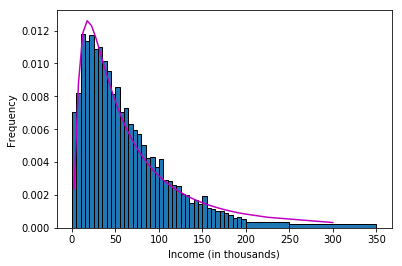

In [91]:
# Plot the histogram of the data
width = np.hstack([np.ones(len(data[:,1]) - 2)*5, 50, 100])
left=data[:,1]/1000

b=np.hstack([data[:, 0][:-2], data[:, 0][-2]/10, data[:, 0][-1]/20])/5
plt.bar(left, b, width, edgecolor='k')
plt.xlabel('Income (in thousands)')
plt.ylabel('Frequency')

# Plot the estimated GMM PDF
x=left*1000
g = lambda x: model_moments_ln(x, mu_ln, sigma_ln)
y = np.zeros(len(xvals))
for i in range(len(xvals)-2):
        y[i] = quad(g, x[i]-2500, x[i] + 2500)[0] 
y[-1]=quad(g, x[-1]-50000, x[-1] + 50000)[0] /20
y[-2]=quad(g, x[-2]-25000, x[-2] + 25000)[0] /10
x=x/1000
y=y/5
plt.plot(x, y, 'm')
plt.show()

# Part(c)

In [34]:
alpha_init  = 3
beta_init = 20000

In [37]:
def model_moments_ga(xvals, alpha, beta):
    
    pdf_vals = 1/((beta ** alpha) * special.gamma(alpha)) * (xvals ** (alpha - 1)) * np.exp(-xvals/beta)
    
    return pdf_vals


def err_vec_ga(xvals,  data_moments, alpha, beta, simple=False):
    

    g = lambda x: model_moments_ga(x, alpha, beta)
    model_moments = np.zeros(len(xvals))
    
    for i in range(len(xvals)):
        model_moments[i] = quad(g, xvals[i]-2500, xvals[i] + 2500)[0]
    if simple:
        err_vec = model_moments - data_moments
    else:
        err_vec = (model_moments - data_moments) / data_moments
    
    return err_vec

def crit_ga(params, *args):
    
    alpha, beta = params
    xvals, frequency, W = args
    err = err_vec_ga(xvals,  data_moments, alpha, beta)
    crit_val = np.dot(np.dot(err.T, W), err) 
    
    return crit_val

In [38]:
bnds1 = ((1e-5, None), (1e-5, None))
params_init1 = (alpha_init, beta_init)

ga_args = (xvals,  data_moments, W)
results1 = opt.minimize(crit_ga, params_init1, args=(ga_args), bounds = bnds1)
print(results1)
alpha_ga, beta_ga = results1.x

      fun: 0.044024590579473645
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([-1.73680514e-06,  1.38777878e-09])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 108
      nit: 28
   status: 0
  success: True
        x: array([1.40615147e+00, 4.55944321e+04])


In [40]:
error=err_vec_ga(xvals, data_moments , alpha_ga, beta_ga, simple=False)
print('Error vector=', error)

Error vector= [-4.46111329e-02  2.19137644e-01 -5.83574754e-02  3.08115336e-03
 -3.38452699e-02  1.14750208e-02 -4.08133738e-02 -1.00282881e-02
 -1.15632737e-02  8.60786378e-02 -3.04062237e-02  9.68115733e-02
 -2.49670425e-02  4.16055332e-02  2.22246756e-02 -1.67841034e-02
  2.76103089e-02  1.15922282e-01  1.18199223e-02  6.74889772e-02
 -1.30370484e-01  1.33706962e-01  6.37302589e-02  6.54720808e-02
 -1.05985272e-02  1.03180167e-01  4.31458639e-02  2.51863656e-01
  1.34864641e-02  6.33704504e-02 -2.60234613e-01  5.83455285e-02
  1.98000343e-02  5.71568908e-02 -5.21313214e-02  3.98997518e-04
  4.46405647e-02  1.99392070e-01  3.77715942e-02  1.44535402e-01
 -9.10323055e-01 -9.84084830e-01]


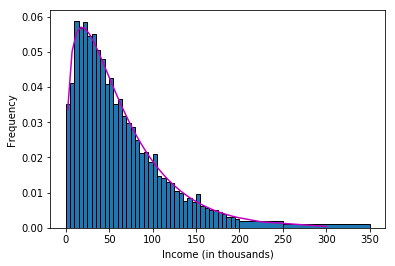

In [45]:
# Plot the histogram of the data
width = np.hstack([np.ones(len(data[:,1]) - 2)*5, 50, 100])
left=data[:,1]/1000
plt.bar(left, np.hstack([data[:, 0][:-2], data[:, 0][-2]/10, data[:, 0][-1]/20]), width, edgecolor='k')
b=np.hstack([data[:, 0][:-2], data[:, 0][-2]/10, data[:, 0][-1]/20])
plt.xlabel('Income (in thousands)')
plt.ylabel('Frequency')

# Plot the estimated GMM PDF
x=left*1000
g = lambda x: model_moments_ga(x, alpha_ga, beta_ga)
y = np.zeros(len(xvals))
for i in range(len(xvals)):
        y[i] = quad(g, x[i]-2500, x[i] + 2500)[0] 
x=x/1000
plt.plot(x, y, 'm',label='GA_dist')



plt.show()


# Part(d)

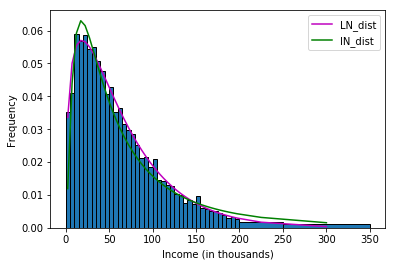

In [46]:
# Plot the histogram of the data
width = np.hstack([np.ones(len(data[:,1]) - 2)*5, 50, 100])
left=data[:,1]/1000
plt.bar(left, np.hstack([data[:, 0][:-2], data[:, 0][-2]/10, data[:, 0][-1]/20]), width, edgecolor='k')
b=np.hstack([data[:, 0][:-2], data[:, 0][-2]/10, data[:, 0][-1]/20])
plt.xlabel('Income (in thousands)')
plt.ylabel('Frequency')
# Plot the estimated GMM PDF
x=left*1000
g = lambda x: model_moments_ga(x, alpha_ga, beta_ga)
y = np.zeros(len(xvals))
for i in range(len(xvals)):
        y[i] = quad(g, x[i]-2500, x[i] + 2500)[0] 
x=x/1000
plt.plot(x, y, 'm',label="GA_dist")


# Plot the estimated GMM PDF
x=left*1000
g = lambda x: model_moments_ln(x, mu_ln, sigma_ln)
y = np.zeros(len(xvals))
for i in range(len(xvals)):
        y[i] = quad(g, x[i]-2500, x[i] + 2500)[0] 
x=x/1000
plt.plot(x, y, 'g',label="IN_dist")
plt.legend()
plt.show()

# Part(e)

In [48]:
W = np.identity(42)

ga_args1 = (xvals, data_moments, W)
results2 = opt.minimize(crit_ga, params_init1, args=(ga_args1), bounds = bnds1)
print(results2)
alpha_ga2, beta_ga2 = results2.x

      fun: 2.124434778949746
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([-0.0002931,  0.       ])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 159
      nit: 28
   status: 0
  success: True
        x: array([1.40908038e+00, 4.46600398e+04])


In [50]:
e = err_vec_ga(xvals, data_moments, alpha_ga2, beta_ga2)
Omega_2 = np.outer(e.T, e) 
W1 = pinv(Omega_2)
params_init2 = (3, 20000)
ga_args3 = (xvals, data_moments, W1)
results3 = opt.minimize(crit_ga, params_init2, args=(ga_args3), bounds = bnds1)
print(results3)
alpha_ga3, beta_ga3 = results3.x

      fun: -2665062953051903.0
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([-7.4500e+10,  1.2425e+11])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 18
      nit: 4
   status: 0
  success: True
        x: array([3.41345623e+00, 1.99999999e+04])


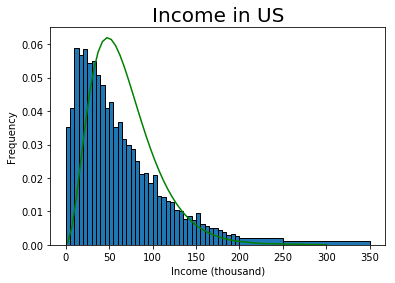

In [51]:
width = np.hstack([np.ones(len(data[:,-1]) - 2)*5, 50, 100])

plt.bar(left, np.hstack([data[:, 0][:-2], data[:, 0][-2]/10, data[:, 0][-1]/20]), width, edgecolor='k')
plt.title('Income in US', fontsize=20)
plt.xlabel('Income (thousand)')
plt.ylabel('Frequency')


x=left*1000
g = lambda x: model_moments_ga(x,alpha_ga3, beta_ga3)
y = np.zeros(len(xvals))
for i in range(len(xvals)):
        y[i] = quad(g, x[i]-2500, x[i] + 2500)[0] 
x=x/1000
plt.plot(x, y, 'g')

plt.show()

